<a href="https://colab.research.google.com/github/Clarke-Jools-36/diss-gw/blob/testing/autoencoder_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am going to attempt to set up a simple autoencoder. First I need to create data on which to test and train the autoencoder. I will create gravitational wave sections 1 second long with 1024 samples. 
I will also create artefacts which are not gravitational waves. 

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
a = np.zeros_like(t) #create an array of zeros to populate with amplitude values

In [ ]:
print(len(a))
print(len(a)==len(t)) #idiot check early :)

1024
True


Lets start with an artifact, a sin wave which has amplidue of a bell curve

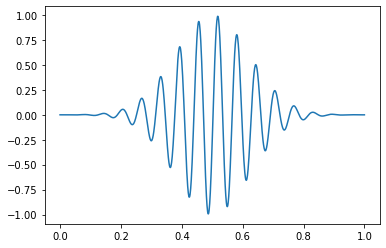

In [ ]:
## SIN WAVE ##
A = 0 #amplitude
B = 0.01 #period
C = 0 #phase shift (horizontal)
D = 0 #amplitude shift (vertical)
## BELL CURVE ##
b = 0.03 #width of bell curve describing amplitude
c = 0.5  #phase shift (horizontal) of bell curve

for i,t_ in enumerate(t):
  A = np.e**( -((t_-c)**2 / b) ) #setting amplidude to bell curve
  #plt.plot(t_, A, "x")

  a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

plt.plot(t,a)

We can also make the frequency of the sin wave lower at the tail ends. 

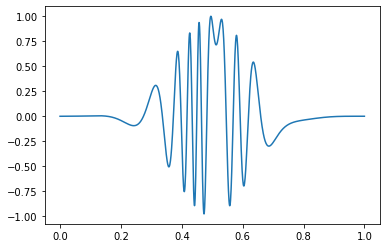

In [ ]:
for i,t_ in enumerate(t):
  A = np.e**( -((t_-c)**2 / b) ) #setting amplidude to bell curve
  
  B = -0.035 * (np.e**( -((t_-c)**2 / b) )) + 0.05 #setting freq to bell curve
  #plt.plot(t_, B, "x")
  a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

plt.plot(t,a)

Something funky is happening here, potentially because of the syncing with the sample rate?

Lets move on to grav wave like signals. These are less symettrical



In [ ]:
t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
a = np.zeros_like(t) #create an array of zeros to populate with amplitude values

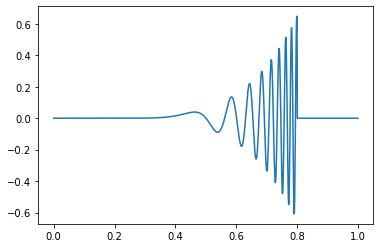

In [ ]:
## SIN WAVE ##
A = 0 #amplitude
B = 0.01 #period
C = 0 #phase shift (horizontal)
D = 0 #amplitude shift (vertical)
## POLYNOMIAL ##
b = 2 #amplitude of amplitude polynomial
c = 0.005 #amplitude of freq polynomial
d = 5 #degree of polynomial
for i,t_ in enumerate(t):
  if 0<t_<0.8:
    A = 2*t_**5 # amplitude increases with polynomial 5
    B = 0.005/t_**5 #freq increases
  else:
    A = 0

  a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

plt.plot(t,a)

Lets make some functions, and save this data

In [84]:
def blip(seed = None):
  if seed == None:
    seed = np.random.randint(0,999999)
  np.random.seed(seed)


  t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
  a = np.zeros_like(t) #create an array of zeros to populate with amplitude values
  A,B,C,D,b,c = 0,0.01,((np.random.rand()-0.5)),0,0.03 + (0.05*(np.random.rand()-0.5)),0.5 + (0.5*(np.random.rand()-0.5))

  randomA = (0.5*(np.random.rand()-0.5)) #maximum amplitude

  for i,t_ in enumerate(t):
    A = randomA * np.e**( -((t_-c)**2 / b) ) #setting amplidude to bell curve
    a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

  return {"data":{"time":t,"amplitude":a},"seed":seed}


In [121]:
def wave(seed = None):
  if seed == None:
    seed = np.random.randint(0,999999)
  np.random.seed(seed)


  t = np.linspace(0,1,1024) #create an array of time between 0 and 1 second with 1024 samples
  a = np.zeros_like(t) #create an array of zeros to populate with amplitude values

  A,B,C,D,b,c,d = 0,0.01,((np.random.rand()-0.5)),0,2 + ((np.random.rand()-0.5)),0.005 + (0.001*(np.random.rand()-0.5)),5

  randomA = (0.5*(np.random.rand()-0.5)) #maximum amplitude

  for i,t_ in enumerate(t):
    if 0<t_<0.75+C/2:
      A = randomA * 2*t_**5 # amplitude increases with polynomial 5
      B = 0.005/t_**5 #freq increases
    else:
      A = 0

    a[i] = A * np.sin( (1/B) * (t_ - C) ) + D

  return {"data":{"time":t,"amplitude":a},"seed":seed}



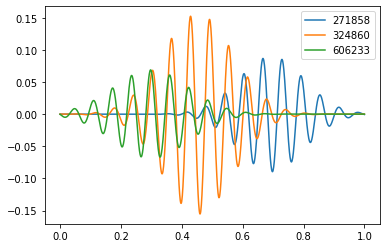

In [85]:
blip_ = blip()
plt.plot(blip_["data"]["time"],blip_["data"]["amplitude"], label = blip_["seed"])
blip_ = blip()
plt.plot(blip_["data"]["time"],blip_["data"]["amplitude"], label = blip_["seed"])
blip_ = blip()
plt.plot(blip_["data"]["time"],blip_["data"]["amplitude"], label = blip_["seed"])

plt.legend()

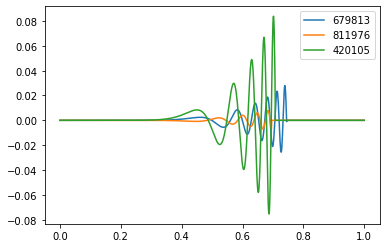

In [123]:
wave_ = wave()
plt.plot(wave_["data"]["time"],wave_["data"]["amplitude"], label = wave_["seed"])
wave_ = wave()
plt.plot(wave_["data"]["time"],wave_["data"]["amplitude"], label = wave_["seed"])
wave_ = wave()
plt.plot(wave_["data"]["time"],wave_["data"]["amplitude"], label = wave_["seed"])


plt.legend()